In [1]:
import xarray as xr
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from datetime import datetime

import glob
import dask
import warnings
import cartopy
import pickle

from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

import sys
sys.path.insert(0, "/user/work/eh19374/LPDM-emulation-trees_TESTING/")
from trees_emulator.load_data import *
from trees_emulator.training import *
from trees_emulator.predicting import *

import warnings
warnings.filterwarnings('ignore')

In [2]:
# run this so loaded functions/packages get automatically updated if you edit
%load_ext autoreload
%autoreload 2

### Loading Datasets
- 2014/15 coarsened
- 2016 coarsened 2x
- 2016 coarsened 4x
- 2016 no coarsening

In [33]:
# load the data for a particular site
site = "MHD"

domains = {"MHD":"EUROPE", "THD":"USA", "TAC":"EUROPE", "RGL":"EUROPE", "HFD":"EUROPE", "BSD":"EUROPE", "GSN":"EASTASIA"}
heights = {"MHD":"10magl", "THD":"10magl", "TAC":"185magl", "RGL":"90magl", "HFD":"100magl", "BSD":"250magl", "GSN":"10magl"} # default heights

## for UK/Ireland sites (MHD, TAC, RGL, BSD, HFD)
met_datadir = "/group/chemistry/acrg/met_archive/NAME/EUROPE_met/EUROPE_Met_10magl_*"
fp_datadir = f"/group/chemistry/acrg/LPDM/fp_NAME/EUROPE/{site}-{heights[site]}_UKV_EUROPE_*"
extramet_datadir = "/group/chemistry/acrg/met_archive/NAME/full_extra_vars/EUROPE*"
## for GSN (South Korea)
# met_datadir = "/group/chemistry/acrg/met_archive/NAME/other_met/EASTASIA_Met_*"
# fp_datadir = "/group/chemistry/acrg/LPDM/fp_Elena/EASTASIA/GSN_*"
# extramet_datadir = "/group/chemistry/acrg/met_archive/NAME/full_extra_vars/EASTASIA*"

## for THD (California)
# met_datadir = "/group/chemistry/acrg/met_archive/NAME/other_met/USA_Met_*" # for TAC
# fp_datadir = "/group/chemistry/acrg/LPDM/fp_Elena/USA/THD_*"
# extramet_datadir = "/group/chemistry/acrg/met_archive/NAME/full_extra_vars/USA*"


# data_201415_coarse2 = LoadData(year="201[4-5]", site=site, coarsen_factor=cf, verbose=True, met_datadir=met_datadir, fp_datadir=fp_datadir, extramet_datadir=extramet_datadir)
data_2016_coarse2 = LoadData(year="2016", site=site, size=9, coarsen_factor=2, verbose=True, met_datadir=met_datadir, fp_datadir=fp_datadir, extramet_datadir=extramet_datadir)
data_2016_coarse3 = LoadData(year="2016", site=site, coarsen_factor=4, verbose=True, met_datadir=met_datadir, fp_datadir=fp_datadir, extramet_datadir=extramet_datadir)
data_2016 = LoadData(year="2016", site=site, verbose=True, met_datadir=met_datadir, fp_datadir=fp_datadir, extramet_datadir=extramet_datadir)

Loading Meteorology data from /group/chemistry/acrg/met_archive/NAME/EUROPE_met/EUROPE_Met_10magl_*2016*.nc
Loading footprint data from /group/chemistry/acrg/LPDM/fp_NAME/EUROPE/MHD-10magl_UKV_EUROPE_*2016*.nc
Cutting data to size
[51.328    51.795998 52.264    52.732002 53.2      53.668    54.136
 54.604    55.072   ] [-12.892    -12.188    -11.483999 -10.780001 -10.076     -9.372
  -8.667999  -7.964     -7.26    ]
Loading extra meteorology from /group/chemistry/acrg/met_archive/NAME/full_extra_vars/EUROPE*2016*.nc and extracting gradients
Extracting wind vectors
All data loaded
Loading Meteorology data from /group/chemistry/acrg/met_archive/NAME/EUROPE_met/EUROPE_Met_10magl_*2016*.nc
Loading footprint data from /group/chemistry/acrg/LPDM/fp_NAME/EUROPE/MHD-10magl_UKV_EUROPE_*2016*.nc
Cutting data to size
[48.988    49.924004 50.86     51.796    52.732002 53.668    54.604
 55.54     56.475998 57.412003] [-16.412     -15.004     -13.596001  -12.188     -10.78       -9.372
  -7.9639997 

Text(0.5, 1.0, 'Black = Original\nWhite = 2x Coarsen')

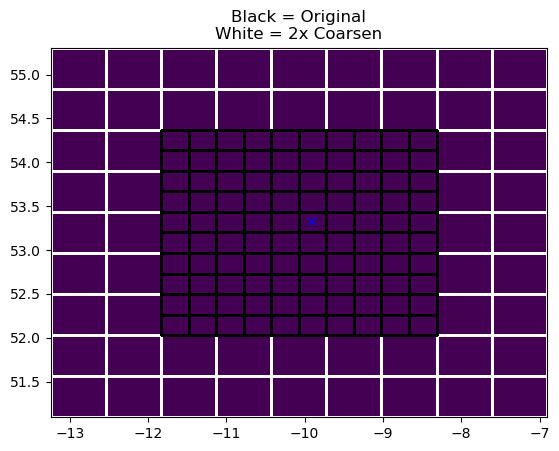

In [35]:
lonmesh_OG, latmesh_OG = np.meshgrid(data_2016.fp_lons, data_2016.fp_lats)
lonmesh_2, latmesh_2 = np.meshgrid(data_2016_coarse2.fp_lons, data_2016_coarse2.fp_lats)

fig, ax = plt.subplots(1,1)
ax.pcolormesh(lonmesh_2, latmesh_2, np.zeros_like(lonmesh_2), edgecolors='white')
ax.pcolormesh(lonmesh_OG, latmesh_OG, np.zeros_like(lonmesh_OG), edgecolors='black')
ax.plot(data_2016.release_lon, data_2016.release_lat, 'bx')
ax.set_title('Black = Original\nWhite = 2x Coarsen')

#### Inputs for coarsened 14/15 and 16

In [4]:
# Passback hours for testing
hoursbefore_6 = [6]
hoursbefore_12 = [12]
hoursbefore_6_12 = [6,12]

In [5]:
## variables that are passed at the time of the footprint and x hours before
vars_with_past = [data_201415_coarse2.y_wind, data_201415_coarse2.x_wind, data_201415_coarse2.met.PBLH.values]
## variables that are only passed at the time of the footprint
vars_without_past = [data_201415_coarse2.temp_grad, data_201415_coarse2.x_wind_grad, data_201415_coarse2.y_wind_grad]

inputs_1415_coarse = get_all_inputs_v3(vars_with_past, hoursbefore_6, vars_without_past, size=16)

In [6]:
## variables that are passed at the time of the footprint and x hours before
vars_with_past = [data_2016_coarse2.y_wind, data_2016_coarse2.x_wind, data_2016_coarse2.met.PBLH.values]
## variables that are only passed at the time of the footprint
vars_without_past = [data_2016_coarse2.temp_grad, data_2016_coarse2.x_wind_grad, data_2016_coarse2.y_wind_grad]

inputs_16_coarse = get_all_inputs_v3(vars_with_past, hoursbefore_6, vars_without_past, size=16)

In [7]:
# Alpha testing

tree_num = 55

alpha = train_tree(data = data_201415_coarse2,
                   inputs = inputs_1415_coarse,
                   frequency = 2, 
                   hours_back = max(hoursbefore_6), 
                   tree = tree_num)

alpha_truths, alpha_predictions = predict_tree(clf = alpha, 
                                               data = data_2016_coarse2,
                                               inputs = inputs_16_coarse, 
                                               hours_back = max(hoursbefore_6),
                                               tree = tree_num, 
                                               return_truths = True)

#### Alpha Truths vs Predictions (R2)

In [8]:
print(f'Alpha = {r2_score(alpha_truths, alpha_predictions):.2f}')

Alpha = 0.72


#### Loading original (no coarsening)

In [9]:
## variables that are passed at the time of the footprint and x hours before
vars_with_past = [data_2016.y_wind, data_2016.x_wind, data_2016.met.PBLH.values]
## variables that are only passed at the time of the footprint
vars_without_past = [data_2016.temp_grad, data_2016.x_wind_grad, data_2016.y_wind_grad]

inputs_16_OG = get_all_inputs_v3(vars_with_past, hoursbefore_6, vars_without_past, size=16)

# Load trained model. Info is a dict with general info about the training, clfs is a list of length size**2 with all regressors
with open(f'/group/chemistry/acrg/ef17148/trained_tree_models/{site}.txt', 'rb') as f:
    [info, clfs] = pickle.load(f)
print("Trained model info:", info)

predictionsOG = MakePredictions(clfs, data_2016, inputs_16_OG, max(hoursbefore_6))

Trained model info: {'site': {'MHD'}, 'training data': '201[4-5]', 'sampling frequency': 2, 'size': 10}


#### Alpha test vs OG Predictions

Alpha = 0.29
Saved Model = 0.67


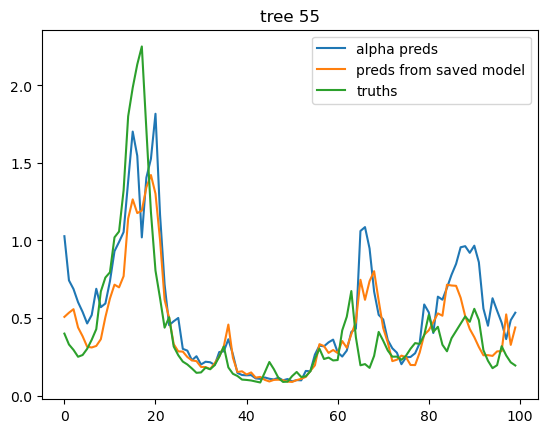

In [10]:
plt.plot(alpha_predictions[100:200], label="alpha preds") 
plt.plot(predictionsOG.predictions[:,tree_num][100:200], label="preds from saved model")
plt.plot(predictionsOG.truths[:,tree_num][100:200], label="truths")
plt.legend()
plt.title(f"tree {tree_num}")

# Print score
print(f'Alpha = {r2_score(predictionsOG.truths[:,tree_num], alpha_predictions):.2f}')
print(f'Saved Model = {r2_score(predictionsOG.truths[:,tree_num], predictionsOG.predictions[:,tree_num]):.2f}')

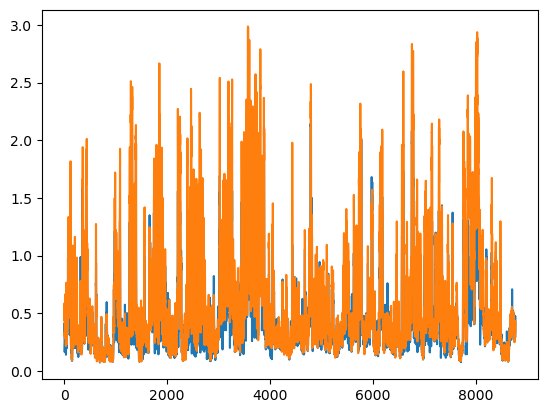

In [11]:
plt.plot(predictionsOG.predictions[:,55])
plt.plot(alpha_predictions)


#### 2x Coarsened Model

In [12]:
# Loading coarsened trained model
with open(f'/user/work/eh19374/LPDM-emulation-trees_TESTING/trained_models/v3_MHD_1415_coarsened2.txt', 'rb') as f:
    [info, clfs] = pickle.load(f)
print("Trained model info:", info)

# Coarsened Predictions
coarse_predictions_v3_2 = MakePredictions(clfs, data_2016_coarse2, inputs_16_coarse, max(hoursbefore_6))

Trained model info: {'site': 'MHD', 'training data': '201[4-5]', 'sampling frequency': 2, 'size': 10}


R2 = 0.40


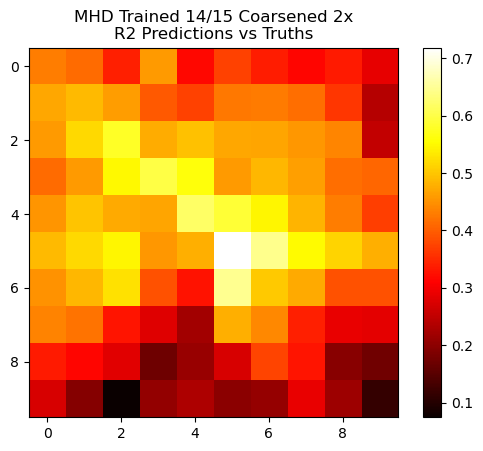

In [13]:
r2 = []
for x in range(100):
    r2.append(r2_score(coarse_predictions_v3_2.truths[:,x], coarse_predictions_v3_2.predictions[:,x]))
r2_grid = np.reshape(r2, (10,10))
plt.imshow(r2_grid, cmap='hot')
plt.colorbar()
plt.title('MHD Trained 14/15 Coarsened 2x\nR2 Predictions vs Truths')
print(f"R2 = {r2_score(coarse_predictions_v3_2.truths, coarse_predictions_v3_2.predictions):.2f}") 

#### 4x Coarsened Model

In [14]:
# Loading coarsened trained model
with open(f'/user/work/eh19374/LPDM-emulation-trees_TESTING/trained_models/v3_MHD_1415_coarsened4.txt', 'rb') as f:
    [info, clfs] = pickle.load(f)
print("Trained model info:", info)

Trained model info: {'site': 'MHD', 'training data': '201[4-5]', 'sampling frequency': 2, 'size': 10}


In [15]:
## variables that are passed at the time of the footprint and x hours before
vars_with_past = [data_2016_coarse4.y_wind, data_2016_coarse4.x_wind, data_2016_coarse4.met.PBLH.values]
## variables that are only passed at the time of the footprint
vars_without_past = [data_2016_coarse4.temp_grad, data_2016_coarse4.x_wind_grad, data_2016_coarse4.y_wind_grad]

inputs_16_coarse_4 = get_all_inputs_v3(vars_with_past, hoursbefore_6, vars_without_past, size=16)

R2 = 0.24


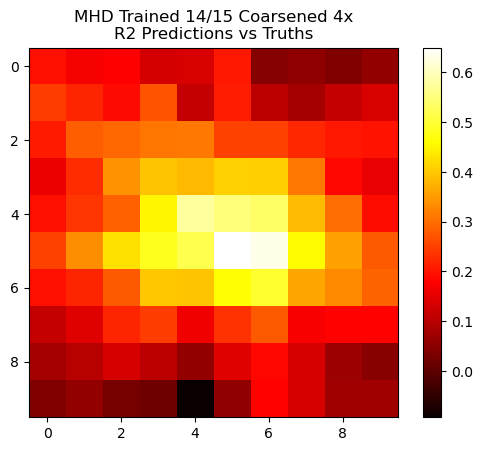

In [16]:
# Coarsened Predictions (inc. interpolation back to original resolution)
coarse_predictions_v3_4 = MakePredictions(clfs, data_2016_coarse4, inputs_16_coarse_4, max(hoursbefore_6))

r2 = []
for x in range(100):
    r2.append(r2_score(coarse_predictions_v3_4.truths[:,x], coarse_predictions_v3_4.predictions[:,x]))
r2_grid = np.reshape(r2, (10,10))
plt.imshow(r2_grid, cmap='hot')
plt.colorbar()
plt.title('MHD Trained 14/15 Coarsened 4x\nR2 Predictions vs Truths')
print(f"R2 = {r2_score(coarse_predictions_v3_4.truths, coarse_predictions_v3_4.predictions):.2f}")

Text(0.5, 1.0, '4x coarsening\nMHD 02/11/2016, 22:00')

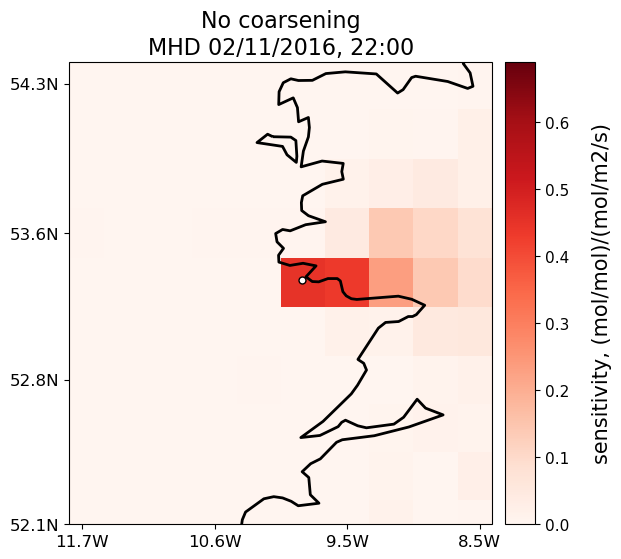

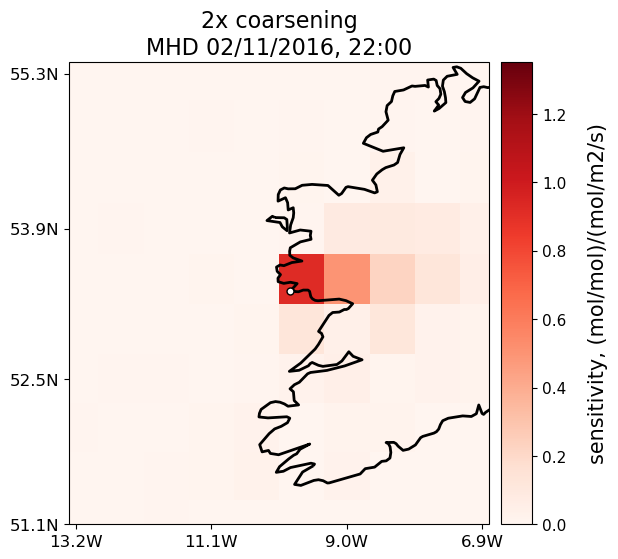

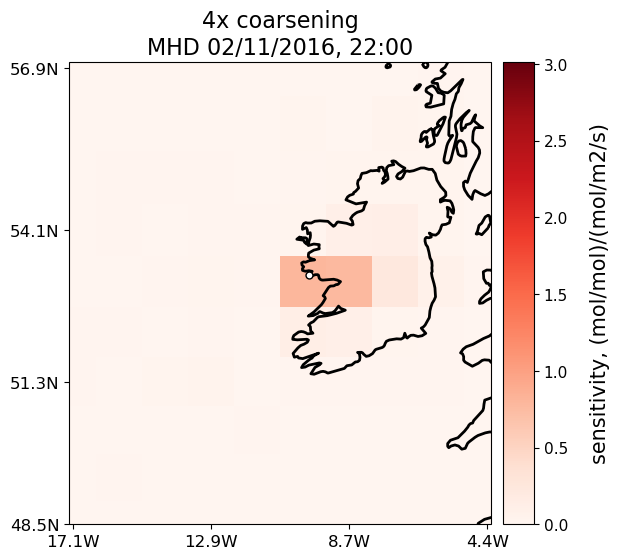

In [23]:
time = 1000
predictionsOG.plot_footprint_single(time)
plt.title('No coarsening\nMHD 02/11/2016, 22:00', fontsize=16)
coarse_predictions_v3_2.plot_footprint_single(time)
plt.title('2x coarsening\nMHD 02/11/2016, 22:00', fontsize=16)
coarse_predictions_v3_4.plot_footprint_single(time)
plt.title('4x coarsening\nMHD 02/11/2016, 22:00', fontsize=16)

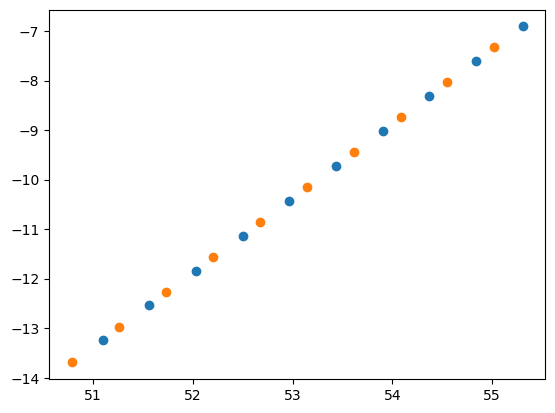

In [18]:
x1 = [51.094, 51.562, 52.03, 52.498, 52.966, 53.434, 53.902, 54.37, 54.838, 55.306]
y1 = [-13.2439995, -12.54, -11.836, -11.132, -10.4279995, -9.724, -9.02, -8.316, -7.612, -6.908]

x2 = [50.7833444, 51.25457198, 51.72579956, 52.19702714, 52.66825472, 53.1394823, 53.61070988, 54.08193746, 54.55316504, 55.02439262] 
y2 = [-13.69216488, -12.984536, -12.27690712, -11.56927825, -10.86164937, -10.15402049, -9.44639161, -8.73876273, -8.03113385, -7.32350497]

plt.scatter(x1, y1)
plt.scatter(x2, y2)